### **Домашнее задание: Выбор модели для бинарной классификации**

**Цель**: Провести отбор признаков и настройку гиперпараметров нескольких моделей для бинарной классификации разными методами. Сравнить результаты и выбрать лучшую модель.

Задание считается выполненным успешно, если будет обучено по крайней мере три модели, среди которых выбрана лучшая по тестовым метрикам.

Ноутбуки направить на почту simon.ilishaev@gmail.com. В теме письма - [FEFU_SBER]


#### **Данные и начальная настройка**  
1. [Загрузите датасет](https://archive.ics.uci.edu/dataset/848/secondary+mushroom+dataset) (числовые и категориальные признаки, бинарная целевая переменная).  
2. Сделайте **стратифицированное разделение на train-test** (например, 70-30). **Тестовый набор** будет использоваться **только для финальной оценки модели**.

#### Подход с разделением на train-validation  
1. Разделите ещё раз **обучающую выборку (train)** на train-validation** (например, 80-20).  
2. Проведите **отбор признаков с помощью фильтрационных методов** на **train-подвыборке**.  
3. Настройте гиперпараметры (например, `C` для логистической регрессии, `max_depth` для дерева решений и т. д.) на **валидационной выборке**.  
4. **Опционально**: Используйте **Differential Evolution из Scipy** для оптимизации гиперпараметров логистической регрессии.  

#### Подход с кросс-валидацией  
1. Используйте **кросс-валидацию (CV)** для **отбора признаков и настройки гиперпараметров**.  
2. Реализуйте **GridSearchCV** для перебора гиперпараметров.  
3. **Опционально**: Используйте **Optuna** с **многокритериальной оптимизацией** (максимизация ROC-AUC и Precision-Recall AUC).  
4. **Опционально**: Визуализируйте **Парето-фронт** для испытаний Optuna.  

#### **Финальная оценка моделей**  
1. Оцените все настроенные модели на **тестовом наборе** (ROC-AUC, Precision-Recall AUC, F1-score).  
2. **Выберите лучшую модель** на основе тестовых метрик.  

### **Модели для использования**  
- Логистическая регрессия (`LogisticRegression`)  
- Дерево решений (`DecisionTreeClassifier`)  
- Случайный лес (`RandomForestClassifier`)
- ...

### Документация

[Scikit-Learn Cross-Validation](https://scikit-learn.org/stable/modules/cross_validation.html)

[Category Encoders](https://contrib.scikit-learn.org/category_encoders/)

[Grid Search](https://scikit-learn.org/stable/modules/grid_search.html)

[Optuna example](https://github.com/optuna/optuna-examples/blob/main/sklearn/sklearn_simple.py)

[Pareto front](https://optuna.readthedocs.io/en/stable/reference/visualization/generated/optuna.visualization.plot_pareto_front.html#sphx-glr-reference-visualization-generated-optuna-visualization-plot-pareto-front-py)

[Scikit-Leaern Pipeline](https://scikit-learn.org/stable/modules/compose.html)

[Differential Evolution](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.differential_evolution.html)
---

In [ ]:
%%bash
pip install ucimlrepo
pip install category_encoders
pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 15.9 MB/s eta 0:00:00


In [ ]:
# библиотеки, которые могут понадобиться для выполнения задания
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, RepeatedKFold, GridSearchCV
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, average_precision_score
from category_encoders import TargetEncoder
from scipy.optimize import differential_evolution
import optuna
from optuna.visualization import plot_pareto_front
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, precision_recall_curve, auc
from sklearn.metrics import f1_score, precision_score, recall_score

In [ ]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
secondary_mushroom = fetch_ucirepo(id=848)

# data (as pandas dataframes)
X = secondary_mushroom.data.features
y = secondary_mushroom.data.targets

# раскомментируйте, чтобы посмотреть метаданные набора данных
# # metadata
display(secondary_mushroom.metadata)

# # variable information
display(secondary_mushroom.variables)

{'uci_id': 848,
 'name': 'Secondary Mushroom',
 'repository_url': 'https://archive.ics.uci.edu/dataset/848/secondary+mushroom+dataset',
 'data_url': 'https://archive.ics.uci.edu/static/public/848/data.csv',
 'abstract': 'Dataset of simulated mushrooms for binary classification into edible and poisonous.',
 'area': 'Biology',
 'tasks': ['Classification'],
 'characteristics': ['Tabular'],
 'num_instances': 61068,
 'num_features': 20,
 'feature_types': ['Real'],
 'demographics': [],
 'target_col': ['class'],
 'index_col': None,
 'has_missing_values': 'yes',
 'missing_values_symbol': 'NaN',
 'year_of_dataset_creation': 2021,
 'last_updated': 'Wed Apr 10 2024',
 'dataset_doi': '10.24432/C5FP5Q',
 'creators': ['Dennis Wagner', 'D. Heider', 'Georges Hattab'],
 'intro_paper': {'ID': 259,
  'type': 'NATIVE',
  'title': 'Mushroom data creation, curation, and simulation to support classification tasks',
  'authors': 'Dennis Wagner, D. Heider, Georges Hattab',
  'venue': 'Scientific Reports',
  'y

,name,role,type,demographic,description,units,missing_values
0,class,Target,Categorical,None,None,None,no
1,cap-diameter,Feature,Continuous,None,None,None,no
2,cap-shape,Feature,Categorical,None,None,None,no
3,cap-surface,Feature,Categorical,None,None,None,yes
4,cap-color,Feature,Categorical,None,None,None,no
5,does-bruise-or-bleed,Feature,Categorical,None,None,None,no
6,gill-attachment,Feature,Categorical,None,None,None,yes
7,gill-spacing,Feature,Categorical,None,None,None,yes
8,gill-color,Feature,Categorical,None,None,None,no
9,stem-height,Feature,Continuous,None,None,None,no


In [ ]:
# target: p - poisonous (ядовитые), e - edible(съедобные)
y = y['class'].map({'p': 1, 'e': 0})

In [ ]:
# Разделение на train-test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

# Категориальные признаки
cat_cols = list(X.select_dtypes('object').columns)
print(cat_cols)
# Численные признаки
num_cols = [col for col in X.columns if col not in cat_cols + ["target"]]
print(num_cols)

['cap-shape', 'cap-surface', 'cap-color', 'does-bruise-or-bleed', 'gill-attachment', 'gill-spacing', 'gill-color', 'stem-root', 'stem-surface', 'stem-color', 'veil-type', 'veil-color', 'has-ring', 'ring-type', 'spore-print-color', 'habitat', 'season']
['cap-diameter', 'stem-height', 'stem-width']


In [ ]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, stratify=y_train, random_state=42
)

Посмотрим на пропуски в данных

In [ ]:
X_train.isna().sum() / len(X_train)

,0
cap-diameter,0.000000
cap-shape,0.000000
cap-surface,0.232207
cap-color,0.000000
does-bruise-or-bleed,0.000000
gill-attachment,0.162378
gill-spacing,0.413094
gill-color,0.000000
stem-height,0.000000
stem-width,0.000000


Как видно, некоторые фичи лучше всего будет удалить т.к они почти не содержат значений

In [ ]:
drop_cols = ['stem-surface','stem-root', 'veil-type', 'veil-color', 'spore-print-color']

cat_cols = [col for col in cat_cols if col not in drop_cols]

Построим препроцесс данных

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from category_encoders import TargetEncoder
from sklearn.preprocessing import FunctionTransformer

def build_preprocessor(drop_cols, num_cols, cat_cols):

    def drop_columns(X):
        return X.drop(columns=drop_cols)

    num_pipe = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ])

    cat_pipe = Pipeline([
        ("encoder", TargetEncoder(
            cols=cat_cols,
            smoothing=5.0,
            handle_missing="value",
            handle_unknown="value"
        ))
    ])

    col_transform = ColumnTransformer([
        ("num", num_pipe, num_cols),
        ("cat", cat_pipe, cat_cols)
    ])

    preprocessor = Pipeline([
        ("drop_cols", FunctionTransformer(drop_columns)),
        ("transform", col_transform)
    ])

    return preprocessor

In [ ]:
def statistics(y, y_pred, y_proba):
    roc_auc = roc_auc_score(y, y_proba)
    average_precision = average_precision_score(y, y_proba)
    f1 = f1_score(y, y_pred)
    print(f"ROC-AUC: {roc_auc:.3f}")
    print(f"Average precision: {average_precision:.3f}")
    print(f"F1-score: {f1:.3f}")
    print('---'* 20)
    return roc_auc, average_precision, f1

### Validation split

#### LogisticRegression

In [ ]:
lr_pipe = Pipeline([
    ("preprocessor", build_preprocessor(drop_cols, num_cols, cat_cols)),
    ("selector", SelectKBest(score_func=f_classif)),
    ("model", LogisticRegression(max_iter=1000))
])

best_score = 0
best_C = 0

for C in [0.001, 0.01, 0.1, 1, 10, 100]:
    lr_pipe.set_params(model__C=C)
    lr_pipe.fit(X_train, y_train)
    y_pred_proba = lr_pipe.predict_proba(X_val)[:, 1]
    y_pred = lr_pipe.predict(X_val)
    roc_auc, average_precision, f1 = statistics(y_val, y_pred, y_pred_proba)
    if roc_auc > best_score:
      best_score = roc_auc
      best_C = C


ROC-AUC: 0.694
Average precision: 0.758
F1-score: 0.704
------------------------------------------------------------
ROC-AUC: 0.779
Average precision: 0.824
F1-score: 0.747
------------------------------------------------------------
ROC-AUC: 0.795
Average precision: 0.836
F1-score: 0.760
------------------------------------------------------------
ROC-AUC: 0.796
Average precision: 0.837
F1-score: 0.758
------------------------------------------------------------
ROC-AUC: 0.796
Average precision: 0.837
F1-score: 0.757
------------------------------------------------------------
ROC-AUC: 0.796
Average precision: 0.837
F1-score: 0.757
------------------------------------------------------------


In [ ]:
def plot_curves(y, y_pred, y_proba):
  fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
  roc_auc = auc(fpr, tpr)

  plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.4f})", color='darkorange')
  plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
  plt.xlabel("False Positive Rate")
  plt.ylabel("True Positive Rate")
  plt.title("ROC Curve")
  plt.legend(loc="lower right")
  plt.grid()
  plt.tight_layout()
  plt.show()

  precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
  pr_auc = auc(recall, precision)

  plt.plot(recall, precision, label=f"PR curve (AUC = {pr_auc:.4f})", color='navy')
  plt.xlabel("Recall")
  plt.ylabel("Precision")
  plt.title("Precision-Recall Curve")
  plt.legend(loc="upper right")
  plt.grid()
  plt.tight_layout()
  plt.show()

best_C = 1
ROC-AUC: 0.800
Average precision: 0.841
F1-score: 0.765
------------------------------------------------------------


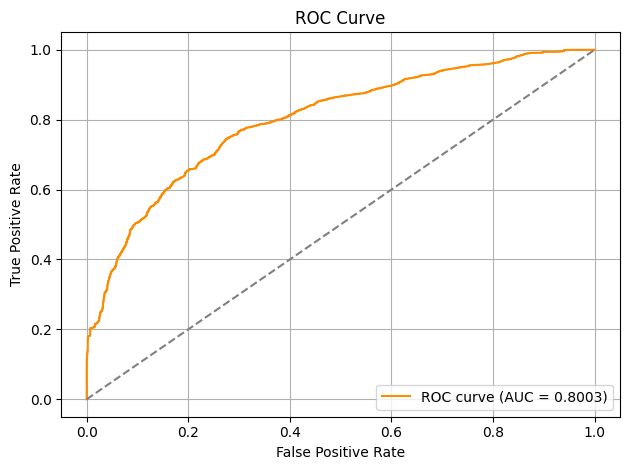

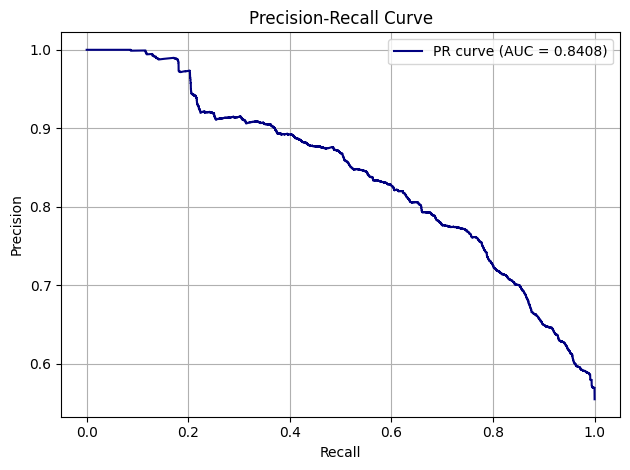

In [ ]:
print(f'best_C = {best_C}')

lr_pipe.set_params(model__C=best_C)
lr_pipe.fit(X_train, y_train)

y_pred_proba = lr_pipe.predict_proba(X_test)[:, 1]
y_pred = lr_pipe.predict(X_test)
roc_auc, average_precision, f1 = statistics(y_test, y_pred, y_pred_proba)

plot_curves(y_test, y_pred, y_pred_proba)

#### DecisionTree

In [ ]:
dt_pipe = Pipeline([
    ("preprocessor", build_preprocessor(drop_cols, num_cols, cat_cols)),
    ("selector", SelectKBest(score_func=f_classif)),
    ("model", DecisionTreeClassifier())
])

best_score = 0
best_max_depth = 0

for max_depth in [3, 5, 7, 10, 15, 20]:
  dt_pipe.set_params(model__max_depth=max_depth)
  dt_pipe.fit(X_train, y_train)
  y_pred_proba = dt_pipe.predict_proba(X_val)[:, 1]
  y_pred = dt_pipe.predict(X_val)
  roc_auc, average_precision, f1 = statistics(y_val, y_pred, y_pred_proba)
  if roc_auc > best_score:
    best_score = roc_auc
    best_max_depth = max_depth

print(f'best_max_depth = {best_max_depth}')


ROC-AUC: 0.732
Average precision: 0.745
F1-score: 0.661
------------------------------------------------------------
ROC-AUC: 0.839
Average precision: 0.852
F1-score: 0.811
------------------------------------------------------------
ROC-AUC: 0.921
Average precision: 0.930
F1-score: 0.844
------------------------------------------------------------
ROC-AUC: 0.985
Average precision: 0.985
F1-score: 0.943
------------------------------------------------------------
ROC-AUC: 0.996
Average precision: 0.994
F1-score: 0.992
------------------------------------------------------------
ROC-AUC: 0.994
Average precision: 0.992
F1-score: 0.995
------------------------------------------------------------
best_max_depth = 15


ROC-AUC: 0.996
Average precision: 0.995
F1-score: 0.992
------------------------------------------------------------


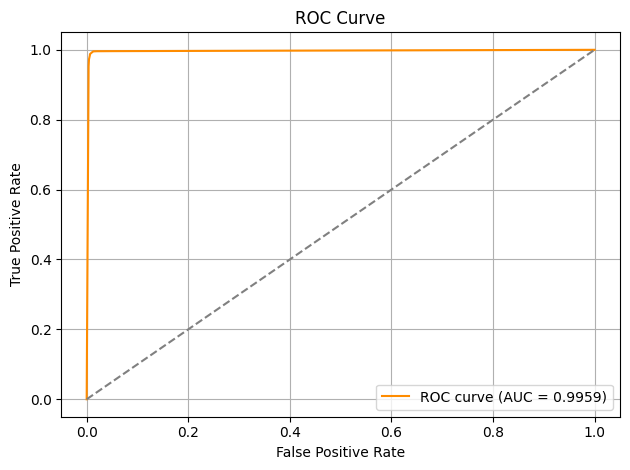

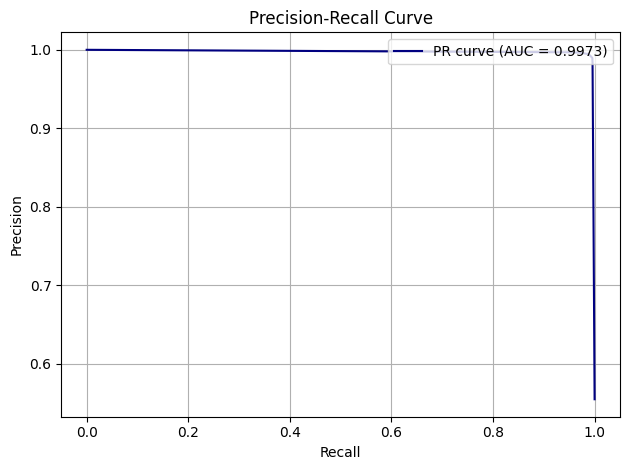

In [ ]:
dt_pipe.set_params(model__max_depth=best_max_depth)
dt_pipe.fit(X_train, y_train)

y_pred_proba = dt_pipe.predict_proba(X_test)[:, 1]
y_pred = dt_pipe.predict(X_test)
roc_auc, average_precision, f1 = statistics(y_test, y_pred, y_pred_proba)

plot_curves(y_test, y_pred, y_pred_proba)

#### RandomForest

In [ ]:
rf_pipe = Pipeline([
    ("preprocessor", build_preprocessor(drop_cols, num_cols, cat_cols)),
    ("selector", SelectKBest(score_func=f_classif)),
    ("model", RandomForestClassifier())
])

best_score = 0
best_max_depth = 0
n_estimators = 0

for max_depth in [3, 5, 7, 10, 15, 20]:
  for n_estimators in [10, 50, 100, 500]:
    rf_pipe.set_params(model__max_depth=max_depth, model__n_estimators=n_estimators)
    rf_pipe.fit(X_train, y_train)
    y_pred_proba = rf_pipe.predict_proba(X_val)[:, 1]
    y_pred = rf_pipe.predict(X_val)
    roc_auc, average_precision, f1 = statistics(y_val, y_pred, y_pred_proba)
    if roc_auc > best_score:
      best_score = roc_auc
      best_max_depth = max_depth
      n_estimators = n_estimators

print(f'best_max_depth = {best_max_depth}')

ROC-AUC: 0.824
Average precision: 0.854
F1-score: 0.789
------------------------------------------------------------
ROC-AUC: 0.838
Average precision: 0.856
F1-score: 0.809
------------------------------------------------------------
ROC-AUC: 0.833
Average precision: 0.859
F1-score: 0.812
------------------------------------------------------------
ROC-AUC: 0.834
Average precision: 0.857
F1-score: 0.810
------------------------------------------------------------
ROC-AUC: 0.906
Average precision: 0.922
F1-score: 0.849
------------------------------------------------------------
ROC-AUC: 0.916
Average precision: 0.930
F1-score: 0.853
------------------------------------------------------------
ROC-AUC: 0.915
Average precision: 0.930
F1-score: 0.864
------------------------------------------------------------
ROC-AUC: 0.916
Average precision: 0.931
F1-score: 0.861
------------------------------------------------------------
ROC-AUC: 0.968
Average precision: 0.975
F1-score: 0.917
--------

In [ ]:
print(f'best_max_depth = {best_max_depth}')
print(f'n_estimators = {n_estimators}')

best_max_depth = 15
n_estimators = 500


ROC-AUC: 1.000
Average precision: 1.000
F1-score: 0.999
------------------------------------------------------------


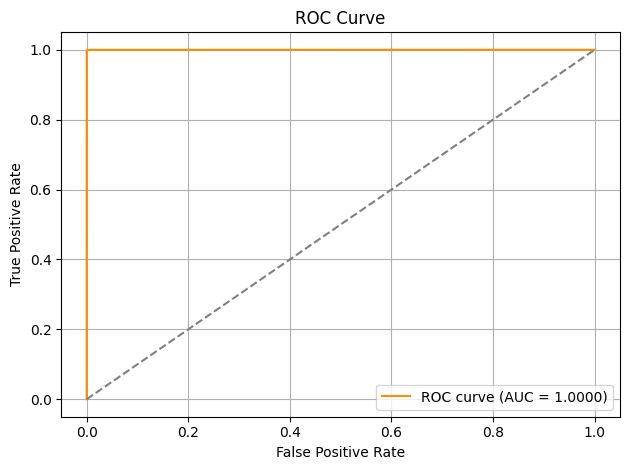

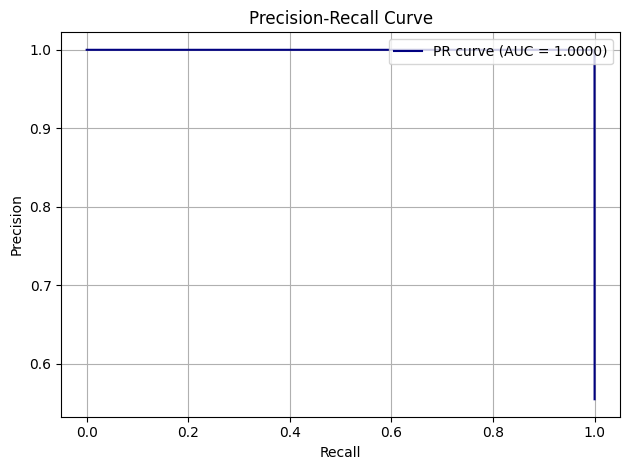

In [ ]:
rf_pipe.set_params(model__max_depth=best_max_depth, model__n_estimators=n_estimators)
rf_pipe.fit(X_train, y_train)
y_pred_proba = rf_pipe.predict_proba(X_test)[:, 1]
y_pred = rf_pipe.predict(X_test)
roc_auc, average_precision, f1 = statistics(y_test, y_pred, y_pred_proba)

plot_curves(y_test, y_pred, y_pred_proba)

#### GradientBoosting

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

gb_pipe = Pipeline([
    ("preprocessor", build_preprocessor(drop_cols, num_cols, cat_cols)),
    ("selector", SelectKBest(score_func=f_classif)),
    ("model", GradientBoostingClassifier())
])

best_score = 0
best_max_depth = 0
n_estimators = 0

for max_depth in [2, 3, 5, 7, 10]:
  for n_estimators in [50, 100, 500, 1000]:
    gb_pipe.set_params(model__max_depth=max_depth, model__n_estimators=n_estimators)
    gb_pipe.fit(X_train, y_train)
    y_pred_proba = gb_pipe.predict_proba(X_val)[:, 1]
    y_pred = gb_pipe.predict(X_val)
    roc_auc, average_precision, f1 = statistics(y_val, y_pred, y_pred_proba)
    if roc_auc > best_score:
      best_score = roc_auc
      best_max_depth = max_depth
      n_estimators = n_estimators

print(f'best_max_depth = {best_max_depth}')
print(f'n_estimators = {n_estimators}')

ROC-AUC: 0.865
Average precision: 0.889
F1-score: 0.800
------------------------------------------------------------
ROC-AUC: 0.888
Average precision: 0.908
F1-score: 0.818
------------------------------------------------------------
ROC-AUC: 0.967
Average precision: 0.974
F1-score: 0.916
------------------------------------------------------------
ROC-AUC: 0.989
Average precision: 0.991
F1-score: 0.956
------------------------------------------------------------
ROC-AUC: 0.918
Average precision: 0.935
F1-score: 0.847
------------------------------------------------------------
ROC-AUC: 0.951
Average precision: 0.961
F1-score: 0.883
------------------------------------------------------------
ROC-AUC: 0.998
Average precision: 0.999
F1-score: 0.986
------------------------------------------------------------
ROC-AUC: 1.000
Average precision: 1.000
F1-score: 0.995
------------------------------------------------------------
ROC-AUC: 0.989
Average precision: 0.992
F1-score: 0.950
--------

ROC-AUC: 1.000
Average precision: 1.000
F1-score: 0.999
------------------------------------------------------------


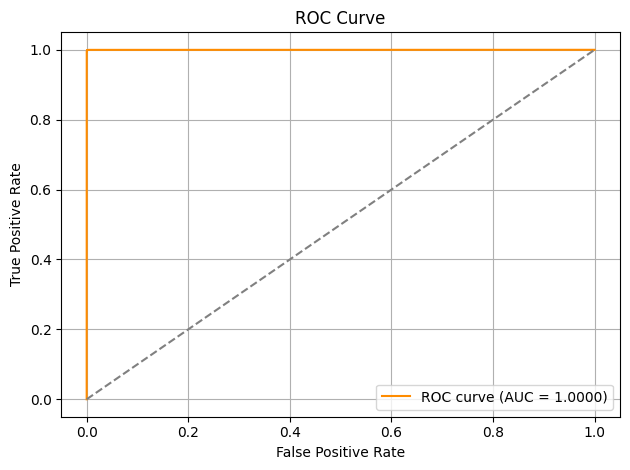

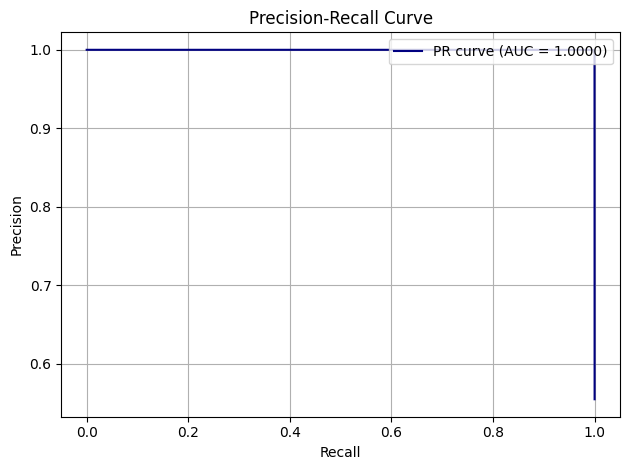

In [ ]:
gb_pipe.set_params(model__max_depth=best_max_depth, model__n_estimators=n_estimators)
gb_pipe.fit(X_train, y_train)
y_pred_proba = gb_pipe.predict_proba(X_test)[:, 1]
y_pred = gb_pipe.predict(X_test)
roc_auc, average_precision, f1 = statistics(y_test, y_pred, y_pred_proba)

plot_curves(y_test, y_pred, y_pred_proba)

### CrossValidation

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

#### LogisticRegrssion cross_val

In [ ]:
lr_pipe = Pipeline([
    ("preprocessor", build_preprocessor(drop_cols, num_cols, cat_cols)),
    ("selector", SelectKBest(score_func=f_classif)),
    ("model", LogisticRegression(max_iter=1000))
])

param_grid = {
    "selector__k": [5, 10, 15],
    "model__C": [0.01, 0.1, 1, 10]
}

cv = RepeatedKFold(n_splits=5, n_repeats=2, random_state=42)
grid_search = GridSearchCV(lr_pipe, param_grid, cv=cv, scoring="roc_auc", n_jobs=-1)

grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_


In [ ]:
grid_search.best_params_

{'model__C': 10, 'selector__k': 15}

ROC-AUC: 0.832
Average precision: 0.868
F1-score: 0.776
------------------------------------------------------------


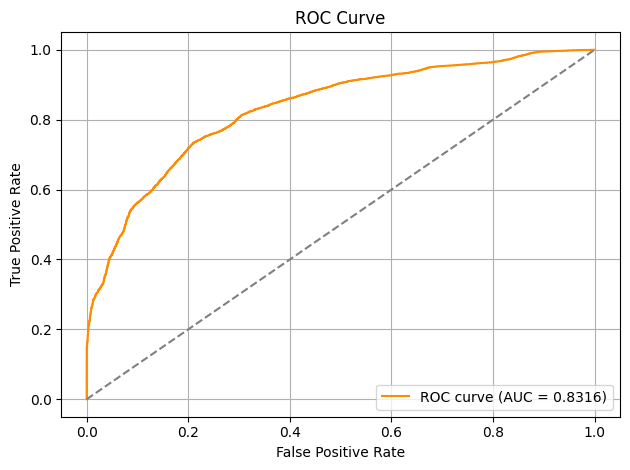

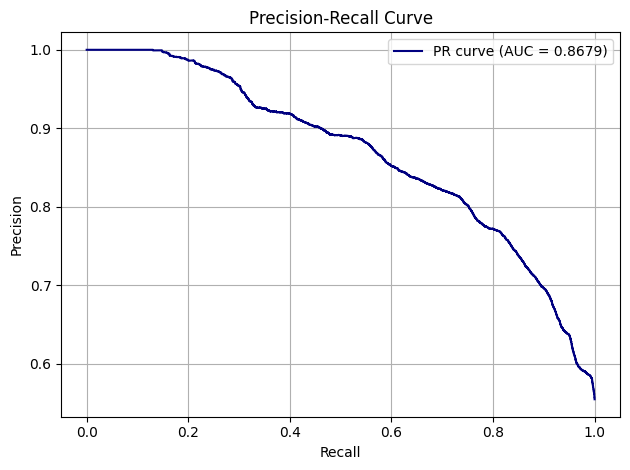

In [ ]:
y_pred_proba = grid_search.predict_proba(X_test)[:, 1]
y_pred = grid_search.predict(X_test)
roc_auc, average_precision, f1 = statistics(y_test, y_pred, y_pred_proba)

plot_curves(y_test, y_pred, y_pred_proba)

#### DecisionTree cross_val

In [ ]:
dt_pipe = Pipeline([
    ("preprocessor", build_preprocessor(drop_cols, num_cols, cat_cols)),
    ("selector", SelectKBest(score_func=f_classif)),
    ("model", DecisionTreeClassifier())
])

param_grid = {
    "selector__k": [5, 10, 15],
    "model__max_depth": [5, 7, 10, 15, 20]
}

cv = RepeatedKFold(n_splits=5, n_repeats=2, random_state=42)
grid_search = GridSearchCV(dt_pipe, param_grid, cv=cv, scoring="roc_auc", n_jobs=-1)

grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_

In [ ]:
grid_search.best_params_

{'model__max_depth': 15, 'selector__k': 15}

ROC-AUC: 0.996
Average precision: 0.996
F1-score: 0.994
------------------------------------------------------------


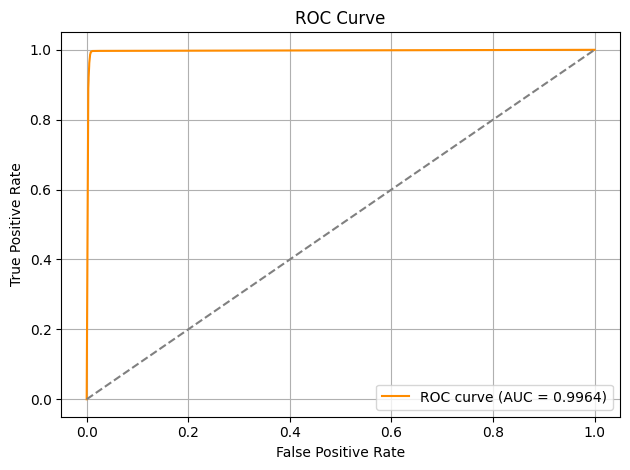

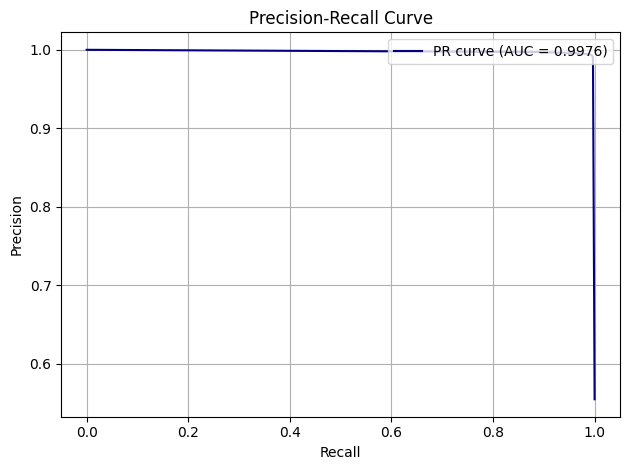

In [ ]:
y_pred_proba = grid_search.predict_proba(X_test)[:, 1]
y_pred = grid_search.predict(X_test)
roc_auc, average_precision, f1 = statistics(y_test, y_pred, y_pred_proba)

plot_curves(y_test, y_pred, y_pred_proba)

#### RandomForest cross_val

In [ ]:
rf_pipe = Pipeline([
    ("preprocessor", build_preprocessor(drop_cols, num_cols, cat_cols)),
    ("selector", SelectKBest(score_func=f_classif)),
    ("model", RandomForestClassifier())
])

param_grid = {
    "selector__k": [10, 15],
    "model__max_depth": [10, 15, 20],
    "model__n_estimators": [100, 500]
}

cv = RepeatedKFold(n_splits=5, n_repeats=2, random_state=42)
grid_search = GridSearchCV(rf_pipe, param_grid, cv=cv, scoring="roc_auc", n_jobs=-1)

grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_

In [ ]:
grid_search.best_params_

{'model__max_depth': 20, 'model__n_estimators': 500, 'selector__k': 15}

ROC-AUC: 1.000
Average precision: 1.000
F1-score: 1.000
------------------------------------------------------------


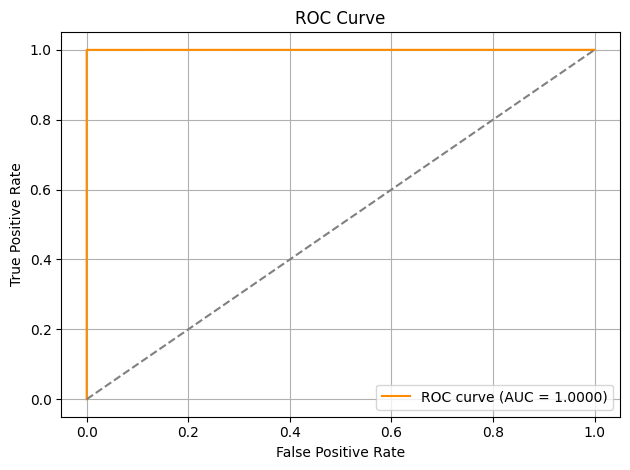

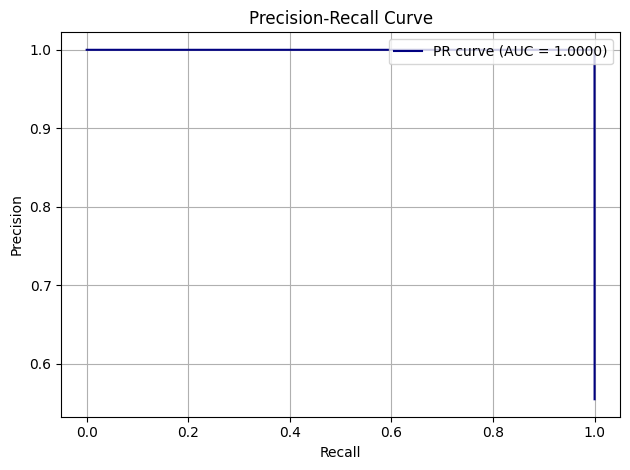

In [ ]:
y_pred_proba = grid_search.predict_proba(X_test)[:, 1]
y_pred = grid_search.predict(X_test)
roc_auc, average_precision, f1 = statistics(y_test, y_pred, y_pred_proba)

plot_curves(y_test, y_pred, y_pred_proba)

#### GradientBoosting cross_val

In [ ]:
gb_pipe = Pipeline([
    ("preprocessor", build_preprocessor(drop_cols, num_cols, cat_cols)),
    ("selector", SelectKBest(score_func=f_classif)),
    ("model", GradientBoostingClassifier())
])

param_grid = {
    "selector__k": [10, 15],
    "model__max_depth": [3, 5, 7],
    'model__n_estimators': [100, 500]
}

cv = RepeatedKFold(n_splits=5, n_repeats=2, random_state=42)
grid_search = GridSearchCV(gb_pipe, param_grid, cv=cv, scoring="roc_auc", n_jobs=-1)

grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_

In [ ]:
grid_search.best_params_

{'model__max_depth': 7, 'model__n_estimators': 500, 'selector__k': 15}

ROC-AUC: 1.000
Average precision: 1.000
F1-score: 1.000
------------------------------------------------------------


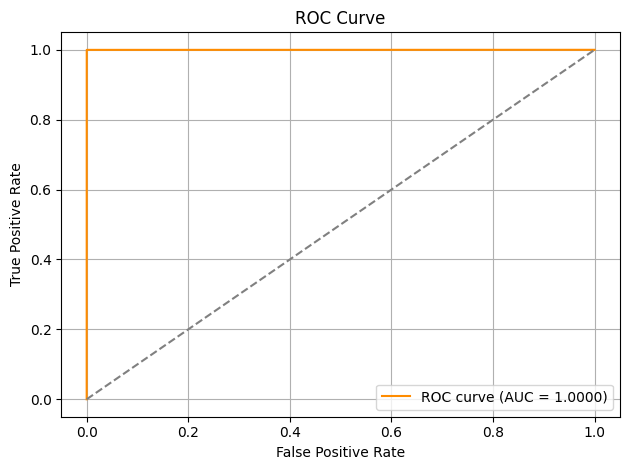

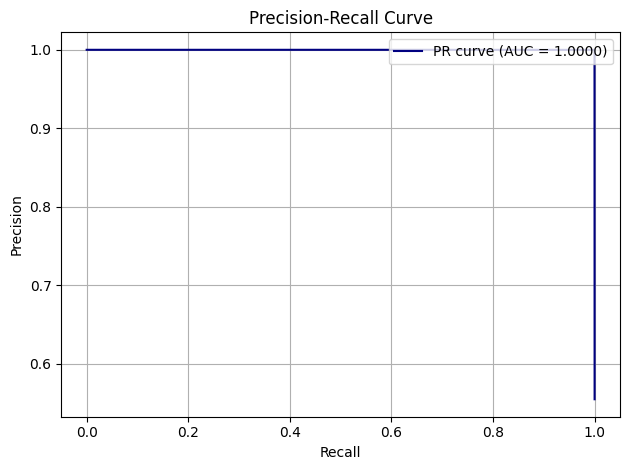

In [ ]:
y_pred_proba = grid_search.predict_proba(X_test)[:, 1]
y_pred = grid_search.predict(X_test)
roc_auc, average_precision, f1 = statistics(y_test, y_pred, y_pred_proba)

plot_curves(y_test, y_pred, y_pred_proba)

### Результат

Из графиков и статистик видно, что с задачей лучше всего справились RandomForest и GradientBoosting, хуже всего LogisticRegression.

При этом RandomForest и GradientBoosting обученные на кросс-валидирующей выборке показали результаты немного лучше, чем при разделении выборки на train, validation, test.


Так как RandomForest более устойчив к выбросам и быстрее обучается, лучше выбрать RandomForest, а не GradientBoosting.

Вывод: RandomForest с параметрами max_depth = 20 и n_estimators = 500, обученный на кросс-валидирующей выборке показывает лучший перфоманс из всех моделей.